In [1]:
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img
from copy import deepcopy
%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Input parameters

In [2]:
pupil_img_size = 39.9988
diam_nominal_ext = 38.542
diam_nominal_int = 10.952
# all-glass diameters
diam_allglass_ext = 36.905
diam_allglass_int = 11.213
r_obstr = diam_allglass_int/diam_allglass_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4  # 0.76
ravc_r = r_obstr/np.sqrt(1 - ravc_t)                           # 0.62 wrt diam_allglass_ext
diam_allglass_RA = ravc_r*diam_allglass_ext  # 22.929 m
# averaged full-M1 diameters
diam_fullM1_ext = 37.812
diam_fullM1_int = 10.196
r_obstr = diam_fullM1_int/diam_fullM1_ext
ravc_t = 1 - (r_obstr**2 + r_obstr*np.sqrt(r_obstr**2 + 8))/4  # 0.79
ravc_r = r_obstr/np.sqrt(1 - ravc_t)                           # 0.59 wrt diam_fullM1_ext
diam_fullM1_RA = ravc_r*diam_fullM1_ext  # 22.265 m
print(diam_allglass_RA, diam_fullM1_RA)

22.928695205442892 22.26468742885102


# Check all-glass vs full-M1

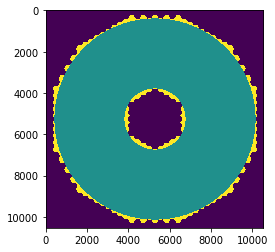

In [3]:
fullM1 = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_M1.fits'))
allglass = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/mask_allglass.fits'))
spiders = np.float32(fits.getdata('/Users/cdelacroix/INSTRUMENTS/METIS/ELT_pupils/SpiderShadow.fits'))
imshow(fullM1 - allglass/2)

# Create dodecagon (ext) and hexagon (int)

In [4]:
def mask_angle(x, y, r, theta, rot):
    P = (r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta)))
    a = np.tan(np.deg2rad(theta - rot))
    b = P[1] - a*P[0]
    mask = (y > a*x + b) + (y > -a*x + b) + (y < a*x - b) + (y < -a*x - b)
    return mask
def dodecagon(r_ext, npupil):
    x, y = cart_coord(npupil)
    M1 = mask_angle(x, y, r_ext, 0 , 90)
    M2 = mask_angle(x, y, r_ext, 30, 90)
    M3 = mask_angle(x, y, r_ext, 60, 90)
    M4 = mask_angle(x, y, r_ext, 90, 90)
    return M1 + M2 + M3 + M4
def hexagon(r_int, npupil):
    x, y = cart_coord(npupil)
    M5 = mask_angle(x, y, r_int, 30, 60)
    M6 = mask_angle(x, y, r_int, 30, 120)
    return ~(M5 + M6)

In [5]:
# a bit of geometry to find the dodecagon and hexagon edges ...
seg_width = 1.45
alpha = np.arcsin(seg_width/diam_allglass_ext)
ds = seg_width*np.sin(np.pi/3)
dc = seg_width*np.cos(np.pi/3)
beta = np.arcsin(dc/diam_allglass_int)
h = np.cos(beta)*diam_allglass_int
diam_dodecagon = np.cos(alpha)*diam_allglass_ext    # 36.877
diam_hexagon = h - ds + seg_width/np.cos(np.pi/6)   # 11.608
print(diam_dodecagon, diam_hexagon)

36.876503698154465 11.608116201010013


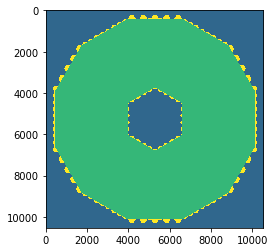

In [6]:
npupil = fullM1.shape[0]
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
mask = dodecagon(r_ext, npupil) + hexagon(r_int, npupil)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

# Lyot stop RAVC
## ls_ravc_allglass

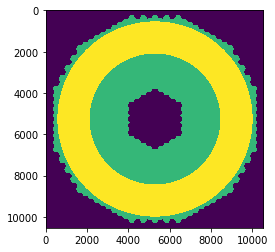

In [7]:
ls_dRext = 0.0282
ls_dRint = 0.0282
r_ext = (diam_allglass_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
r_int = (diam_allglass_RA + ls_dRint*diam_nominal_ext) / pupil_img_size
r, t = polar_coord(npupil)
mask = (r < r_ext) * (r > r_int)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

## ls_ravc_circ

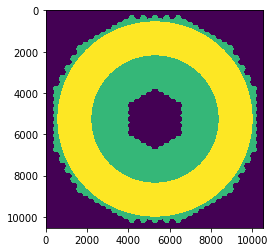

In [8]:
r_ext = (diam_allglass_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
r_int = (diam_fullM1_RA + ls_dRint*diam_nominal_ext) / pupil_img_size
mask = (r < r_ext) * (r > r_int)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

## ls_ravc_dodecagon

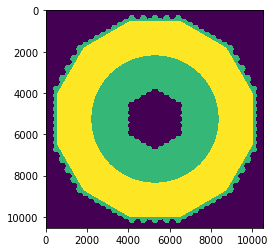

In [9]:
r_ext = (diam_dodecagon - ls_dRext*diam_nominal_ext) / pupil_img_size
r_int = (diam_fullM1_RA + ls_dRint*diam_nominal_ext) / pupil_img_size
mask = ~dodecagon(r_ext, npupil) * (r > r_int)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)
#lyot_stop = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/lyot_stop.fits'
#fits.writeto('ls_ravc_dodecagon_285.fits', resize_img(fits.getdata(lyot_stop)*mask, 285), overwrite=True)

# Lyot stop CVC
## ls_cvc_allglass

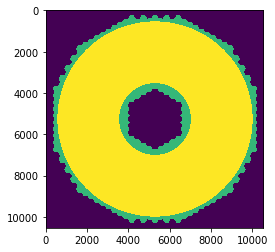

In [10]:
ls_dRext = 0.0282
ls_dRint = 0.05
r_ext = (diam_allglass_ext - ls_dRext*diam_nominal_ext) / pupil_img_size
r_int = (diam_allglass_int + ls_dRint*diam_nominal_ext) / pupil_img_size
mask = (r < r_ext) * (r > r_int)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

## ls_cvc_dodecagon

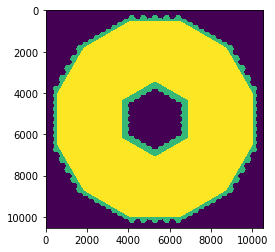

In [11]:
r_ext = (diam_dodecagon - ls_dRext*diam_nominal_ext) / pupil_img_size
r_int = (diam_hexagon + ls_dRint*diam_nominal_ext/np.cos(np.pi/6)) / pupil_img_size
mask = ~dodecagon(r_ext, npupil) * ~hexagon(r_int, npupil)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)
#lyot_stop = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/lyot_stop.fits'
#fits.writeto('ls_cvc_dodecagon_285.fits', resize_img(fits.getdata(lyot_stop)*mask, 285), overwrite=True)

# Lyot stop CLC
## ls_clc_allglass

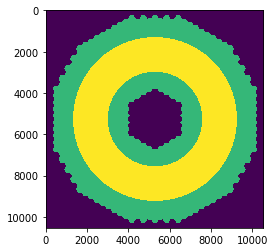

In [12]:
# values from Muskan wrt diam_nominal_ext
r_ext = 0.78 * diam_nominal_ext / pupil_img_size
r_int = 0.45 * diam_nominal_ext / pupil_img_size
mask = (r < r_ext) * (r > r_int)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)

## ls_clc_dodecagon

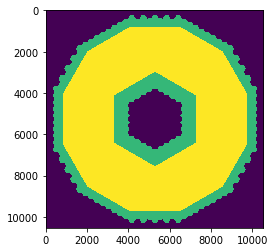

In [13]:
# values from Muskan wrt diam_nominal_ext
r_ext = 0.88 * diam_nominal_ext / pupil_img_size
r_int = 0.45 * diam_nominal_ext / pupil_img_size
mask = ~dodecagon(r_ext, npupil) * ~hexagon(r_int, npupil)
pup = deepcopy(fullM1)
pup[mask] += 0.5
imshow(pup)
#lyot_stop = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/PUPIL/lyot_stop.fits'
#fits.writeto('ls_clc_dodecagon_285.fits', resize_img(fits.getdata(lyot_stop)*mask, 285), overwrite=True)